In [43]:
from torchvision import datasets, transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [44]:
fashion_mnist_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())

train_num = int(len(fashion_mnist_dataset) * 0.8)
val_num = len(fashion_mnist_dataset) - train_num

print(train_num, val_num)

train_data, val_data = torch.utils.data.random_split(fashion_mnist_dataset, [train_num, val_num])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

48000 12000


In [45]:
def get_batch(split):
    data_loader = train_loader if split == 'train' else val_loader
    x, y = next(iter(data_loader))
    return x, y

In [46]:
kernel_size = 3

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size, padding=kernel_size//2)
        self.linear1 = nn.Linear(64*28*28, 100)
        self.linear2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = F.relu(x)
        output = self.linear2(x)
        return output
    
    @torch.no_grad()
    def get_convoluted_images(self, x):
        x = self.conv1(x)
        conv1_output = x
        x = F.relu(x)
        x = self.conv2(x)
        conv2_output = x
        return conv1_output, conv2_output
    
model = ConvNet()

In [47]:
eval_iters = 50

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            loss = F.cross_entropy(model(X), Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [48]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [49]:
def show_batch_images(batch, size):
    rows = int(size / 8)
    cols = 8
    
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(batch[i*rows+j], cmap='gray')
    plt.show()

In [50]:
conv1_images, conv2_images = model.get_convoluted_images(xb[0])

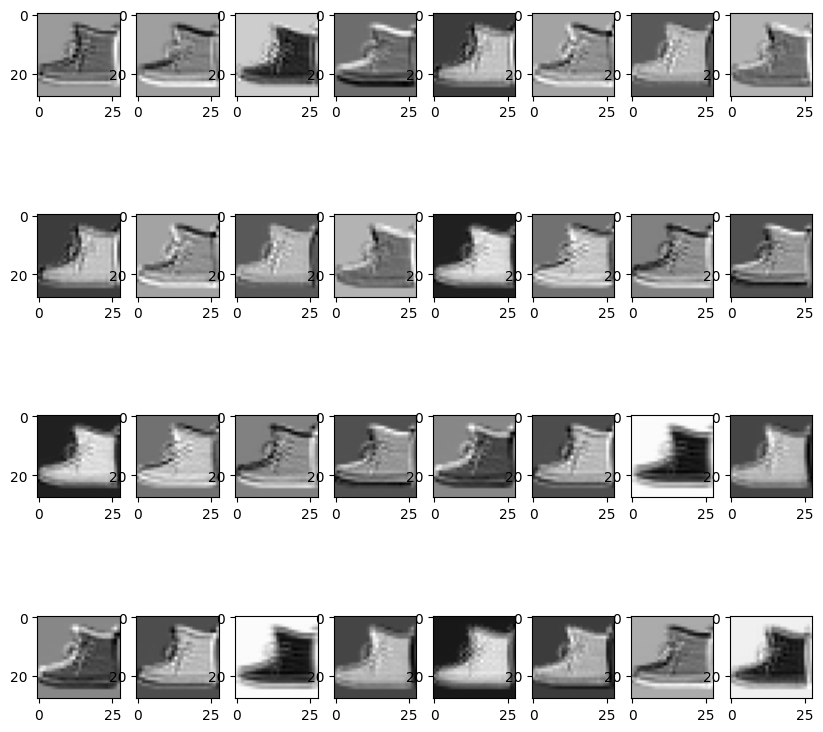

In [51]:
show_batch_images(conv1_images, 32)

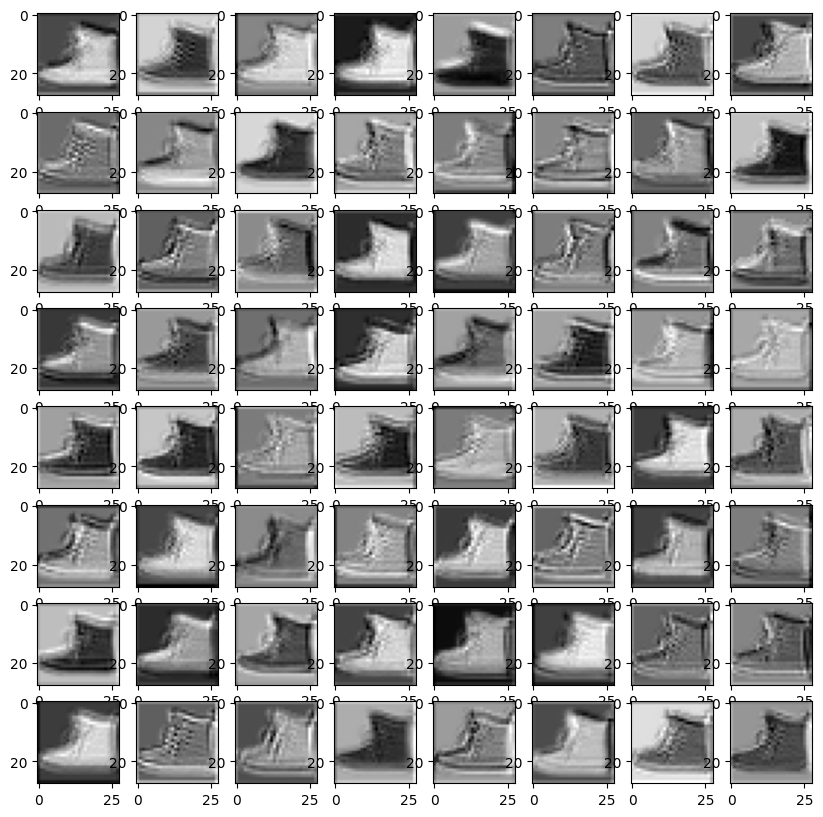

In [52]:
show_batch_images(conv2_images, 64)

In [53]:
max_iters = 1000
eval_interval = 200

for i in range(max_iters):
    
    if i % eval_interval == 0:
        losses = estimate_loss()
        print(f'step {i} | train loss {losses["train"]:.4f} | val loss {losses["val"]:.4f}')
        
    xb, yb = get_batch('train')
    
    # forward pass
    output = model(xb)
    loss = F.cross_entropy(output, yb)
    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0 | train loss 2.3014 | val loss 2.3005
step 200 | train loss 0.4061 | val loss 0.3939
step 400 | train loss 0.3403 | val loss 0.3352
step 600 | train loss 0.2851 | val loss 0.3234
step 800 | train loss 0.2747 | val loss 0.3236


In [54]:
conv1_images, conv2_images = model.get_convoluted_images(xb[0])

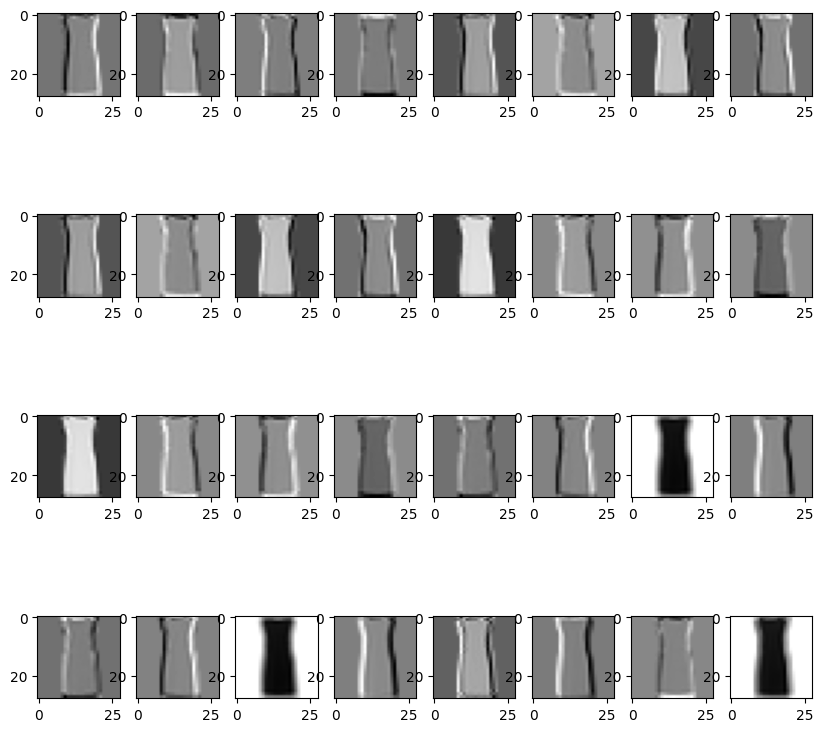

In [55]:
show_batch_images(conv1_images, 32)

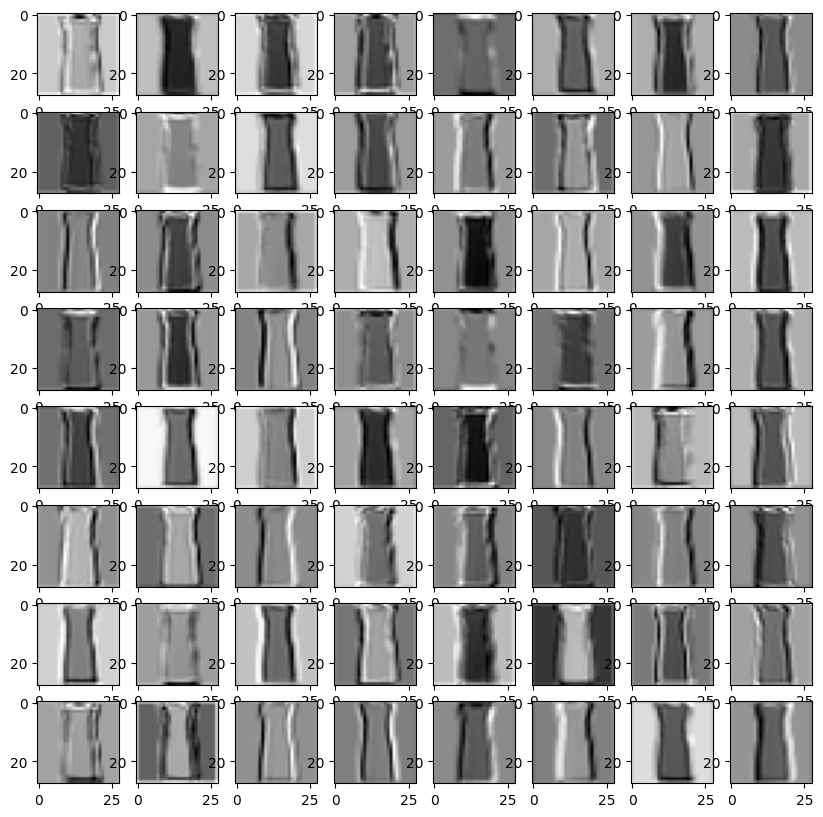

In [56]:
show_batch_images(conv2_images, 64)